<a href="https://colab.research.google.com/github/IamMarcIvanov/DroughtStudiesProject/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
np.random.seed(7)

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
dataset = pd.read_csv('/content/gdrive/My Drive/IMD Rainfall/rain_Point_1.csv', index_col= 0, parse_dates= True)
dataset = dataset.diff(2)
dataset.dropna(inplace= True)

In [5]:
dataset.drop(columns= ['LONGITUDE', 'LATITUDE'], inplace= True)

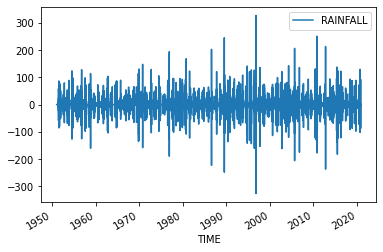

In [6]:
dataset.plot()

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.3)

In [9]:
train = dataset[:train_size]
test = dataset[train_size:]

In [10]:
look_back = 3

In [11]:
def create_dataset(dataset, look_back= 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back - 1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
X_train, y_train = create_dataset(train, look_back)

In [13]:
X_test, y_test = create_dataset(test, look_back)

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units= 64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer= 'Adam')
model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=1, validation_split= 0.1, shuffle= False)

Epoch 1/30
16099/16099 [==============================] - 30s 2ms/step - loss: 0.0024 - val_loss: 7.2681e-04
Epoch 2/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.9685e-04 - val_loss: 7.1493e-04
Epoch 3/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.8340e-04 - val_loss: 7.0455e-04
Epoch 4/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.7329e-04 - val_loss: 6.9099e-04
Epoch 5/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.6476e-04 - val_loss: 6.7505e-04
Epoch 6/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.5723e-04 - val_loss: 6.5645e-04
Epoch 7/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.4984e-04 - val_loss: 6.3757e-04
Epoch 8/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.4253e-04 - val_loss: 6.1938e-04
Epoch 9/30
16099/16099 [==============================] - 28s 2ms/step - loss: 3.3542e-04 - val_loss

In [16]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# # invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [17]:
from sklearn.metrics import mean_absolute_error

In [18]:
trainScore = mean_absolute_error(y_train[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(y_test[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))
r2train = r2_score(y_train[0], trainPredict[:, 0])
print('R2 Score Train: %.2f R2' % (r2train))
r2test = r2_score(y_test[0], testPredict[:, 0])
print('R2 Score Test: %.2f R2' % (r2test))

Train Score: 4.31 MAE
Test Score: 4.90 MAE
R2 Score Train: 0.34 R2
R2 Score Test: 0.33 R2


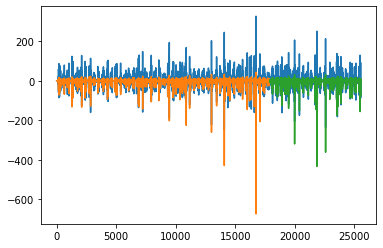

In [19]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [20]:
predicted = testPredict[:, 0]

In [21]:
predicted = abs(pd.DataFrame(predicted))

In [22]:
predicted.min()

0    0.000253
dtype: float32

In [23]:
predicted.max()

0    433.162506
dtype: float32